## Condensation of DCM-Water Mixture

DCM (dichloromethane) and water in a given ratio are distilled under vacuum from a reactor vessel via a primary & secondary condenser system. 

### Purpose:
Determine condensation efficiency of the condensers as function of the gas/vapour temperature reached on exit i.e. the approach to the glycol inlet temperature.

The general configuration is shown below. Heat input via reactor jacket causes boilup. The composition of the vapour evolved is a funciton of the VLE/VLLE behaviour of the mixture as described below. Similarly, the condensation equilibrium also deepends on the VLE/VLLE.

In [2]:
from IPython.display import Image
Image(url="vacuumPumpSchematic.png",width=1200, height=700)

Import necessary packages for the computations. The "phasepy" package is used for the VLE/VLLE calculations.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from phasepy import  component, mixture, virialgamma,  preos
from phasepy.equilibrium import vlleb, vlle, lle, lle_init
from phasepy.equilibrium import bubblePy, bubbleTy, dewPx, dewTx, tpd_min, tpd_minimas
from phasepy.actmodels import nrtl
from scipy.optimize import fsolve

lw = 2

import pandas as pd

NRTL_params = {
    'dichloromethane/water' : {'a12': 0, 'a21': 0, 'b12': 941.429, 'b21': 1483.86, 'c12': 0.3, 'c21': 0.3 },
    # 'THF/water' : {'a12': 1.0, 'a21': 2.0, 'b12': 3.0, 'b21': 4.0, 'c12': 5.0, 'c21': 6.0 },
}
df = pd.DataFrame(NRTL_params)

NRTL_params['dichloromethane/water']['a12']

display(df)


,dichloromethane/water
a12,0.000
a21,0.000
b12,941.429
b21,1483.860
c12,0.300
c21,0.300


## Pure component and mixture properties

The vapour pressure is the only variable required to model pure component condensation.  For mixtures, the NRTL model is used to describe the non-ideal behaviour in the liquid phase. 

In [3]:
water = component(name='water', Mw=18.02, Tc=647.13, Pc=220.55, Zc=0.229, Vc=55.948, 
                  w=0.344861, Ant=[11.64785144, 3797.41566067, -46.77830444],
                  GC={'H2O':1})

dichloromethane = component(name='dichlormethane', Mw=84.93, Tc=510, Pc=61, Zc=0.277, Vc=193, 
                  w=0.268,
                           Ant=[4.53691/np.log10(np.e), 1327.016/np.log10(np.e), -20.474])

print('Water saturation pressure at 373 K: {:0.4f}'.format( water.psat(T=100+273.16), 'bar') )
print('DCM saturation pressure at 381 K: {:0.4f}'.format( dichloromethane.psat(T=39.6+273.16), 'bar') )

mix = mixture(dichloromethane,water)

alpha = np.array([[0.0, NRTL_params['dichloromethane/water']['c12']],
                  [NRTL_params['dichloromethane/water']['c21'], 0.0]])
Aij0 = np.array([[0.0, NRTL_params['dichloromethane/water']['b12']],
              [NRTL_params['dichloromethane/water']['b21'], 0.0]])
Aij1 = np.array([[0.0, NRTL_params['dichloromethane/water']['a12']],
               [NRTL_params['dichloromethane/water']['a21'], 0.0]])

mix.NRTL(alpha, Aij0, Aij1)
# eos = virialgamma(mix, virialmodel='ideal_gas', actmodel='nrtl')  # no virial model, therefore 'ideal gas'
eos = virialgamma(mix, virialmodel='Tsonopoulos', actmodel='nrtl')  # Tsonopoulos model for gas phase

from phasepy.actmodels import nrtl
x = np.array([0.5, 0.5])
T = 350.0

y0 = np.array([0.5, 0.5])
x0 = np.array([0.5, 0.5])
P0 = 1.0
T0 = 350.0
RG = 8.314 # J/mol.K

TBub = []
TDew = []
gamma1 = []
gamma2 = []
y1List = []
y2List = []
sigmaxigammai = []

from thermo.chemical import Chemical
comp1 = Chemical('dichloromethane')
comp1.calculate(T=293, P=101325)
comp2 = Chemical('water')
comp2.calculate(T=293, P=101325)
print("DCM mass density density (kg/m3): {:0.1f}".format( comp1.rhol ) )
print("Water mass density density (kg/m3): {:0.1f}".format( comp2.rhol ) )
print("DCM molar weight (gm/mol): {:0.2f}".format( comp1.MW ) )
print("H2O molar weight (gm/mol): {:0.2f}".format( comp2.MW ) )
print("DCM molar density density (mol/m3): {:0.1f}".format( comp1.rholm ) )
print("Water mass density density (kg/m3): {:0.1f}".format( comp2.rhol ) )
print("Water molar density density (mol/m3): {:0.1f}".format( comp2.rholm ) )

Water saturation pressure at 373 K: 1.0130
DCM saturation pressure at 381 K: 0.9926
DCM mass density density (kg/m3): 1328.1
Water mass density density (kg/m3): 998.3
DCM molar weight (gm/mol): 84.93
H2O molar weight (gm/mol): 18.02
DCM molar density density (mol/m3): 15636.9
Water mass density density (kg/m3): 998.3
Water molar density density (mol/m3): 55411.6


## Initial Conditions in vessel

In [4]:
# Initial vessel conditions
V_DCM = 2600 # litres
V_H2O = 1400 # litres
VTot = 6300 # litres
# Nnc = 1.013*10**5*(VTot/1000)/(RG*(20+273.2))

# Calculate initial mass fraction and mole fractions
MTot = V_DCM/1000*comp1.rhol + V_H2O/1000*comp2.rhol
XInit = [V_DCM/1000*comp1.rhol/MTot, V_H2O/1000*comp2.rhol/MTot]
xInit = [XInit[0]/comp1.MW/(XInit[0]/comp1.MW+XInit[1]/comp2.MW), XInit[1]/comp2.MW/(XInit[0]/comp1.MW+XInit[1]/comp2.MW)]
TInit = 20

print("Mass of DCM initially: {:0.1f} kg".format( V_DCM/1000*comp1.rhol) )
print("Mass of H2O initially: {:0.1f} kg".format( V_H2O/1000*comp2.rhol) )

print("Moles of DCM initially: {:0.2f} kmol".format( V_DCM/1E6*comp1.rholm) )
print("Moles of H2O initially: {:0.2f} kmol".format( V_H2O/1E6*comp2.rholm) )
NTotal_i = V_DCM/1E6*comp1.rholm+V_H2O/1E6*comp2.rholm
print("Total moles initially:  {:0.2f} kmol".format( NTotal_i ))
print("Initial mass fractions [Dichloromethane, Water]: " + ", ".join("%.2f" % f for f in XInit) )
print("Initial mole fractions [Dichloromethane, Water]: " + ", ".join("%.2f" % f for f in xInit) )
  

Mass of DCM initially: 3453.0 kg
Mass of H2O initially: 1397.6 kg
Moles of DCM initially: 40.66 kmol
Moles of H2O initially: 77.58 kmol
Total moles initially:  118.23 kmol
Initial mass fractions [Dichloromethane, Water]: 0.71, 0.29
Initial mole fractions [Dichloromethane, Water]: 0.34, 0.66


## VLLE model for DCM-Water mixture

DCM and water form a highly non-ideal binary mixture. A Txxy diagram depicts the liquid phases, and the location of heterogeneous azeotrope. The NRTL model is used here to calculate the key elements of the diagram.

The NRTL model computes the Gibbs's excess energy as follows:

$$ g^E = \sum_{i=1}^c  x_i \frac{\sum_{j=1}^c \tau_{ji}G_{ji}x_j}{\sum_{l=1}^c G_{li}x_l}$$

Where, 
$$ \tau_{ji} = \frac{A_{ji}}{T}, \quad G_{ji} = \exp{(-\alpha_{ji}\tau_{ji})}, \quad 
\alpha_{ji} = \alpha_{ij} $$

Here $A_{ij}$ and $\alpha_{ij}$ are the interaction energy and aleatory factor between the component $i$ and $j$

In Phasepy, the NRTL's interaction energies are computed as: $A_{ij} = A_{ij, 0} + A_{ij, 1} T$.


#### To calculate the liquid-liquid phase boundaries, firstly calculate minimum values of the tangent-plane function:

In [5]:
T = 320.0
P = 1.013 # bar
z = np.array([xInit[0], xInit[1]])
w = np.array([0.01, 0.99])
print("Liquid molar fractions and TPD value: ", tpd_min(w, z, T, P, eos, stateW='L', stateZ='L'))
print("Vapor molar fractions and TPD value:" , tpd_min(w, z, T, P, eos, stateW='V', stateZ='L'))
print()
print()

nmin = 2
print("TPD liquid minima: ", tpd_minimas(nmin, z, T, P, eos, stateW='L', stateZ='L'))
print("TPD vapor minima: ", tpd_minimas(nmin, z, T, P, eos, stateW='V', stateZ='L'))


Liquid molar fractions and TPD value:  (array([0.0033509, 0.9966491]), -0.22830126466454326)
Vapor molar fractions and TPD value: (array([0.92443148, 0.07556852]), -0.7113397143531432)


TPD liquid minima:  ((array([0.97865422, 0.02134578]), array([0.00335056, 0.99664944])), array([-0.28843753, -0.22830126]))
TPD vapor minima:  ((array([0.92443155, 0.07556845]), array([0.92443155, 0.07556845])), array([-0.71133971, -0.71133971]))


By Gibbs' phase rule, $F = C - P + 2$.

For 2 component system $C=2$, so that $F=2$ (e.g. $T$ and $P$) when 2 phases are present (i.e. vapour & 1 liquid phase). In this case pressure and temperature can be independently specified. 

When 2 liquid phases are present, then $P=3$, so that $F=1$ (e.g. pressure or temperature).  In otherwords, temperature and pressure cannot be independently specified for a flash calculation of abinary mixture with 2 liquid phases and a vapour phase. 

 ### Compute the phase boundaries and composition at the heterogeneous azeotrope:

In [6]:
P = 1.013 # bar
T = 310.0                       # Guess temperature for VLLE calculation
x0 = np.array([0.01, 0.99])     # Guess values for VLLE molefraction (phase 1)
w0 = np.array([0.99, 0.01])     # Guess values for VLLE molefraction (phase 2)
Z = np.array(xInit)             # Overall liquid molefraction
y0 = (x0 + w0)/2                # Guess value for vapour molefraction
VLLE = vlle(x0, w0, y0, Z, T, P, eos, K_tol=1e-11, full_output=True)

TLiq=VLLE.T #[3]
xL1=VLLE.X[0]
xL2=VLLE.X[1]
yLLE=VLLE.X[2]
print('Phase 1 molefraction: ', np.round(xL1,3))
print('Phase 2 molefraction: ', np.round(xL2,3))
print('Vapour molefraction:  ', np.round(yLLE,3))
print('Liquid temperature {:0.3f}'.format( TLiq-273.16) )

Phase 1 molefraction:  [0.003 0.997]
Phase 2 molefraction:  [0.979 0.021]
Vapour molefraction:   [0.931 0.069]
Liquid temperature 38.637


c:\Users\paulx\OneDrive\Documents\Technical_Projects\Python\VacuumPump\env\lib\site-packages\phasepy\equilibrium\hazt.py:258: UserWarning: Global mixture is a binary mixture, updating temperature
  warn('Global mixture is a binary mixture, updating temperature')


In [7]:
TLiq=VLLE.T #[3]
xL1=VLLE.X[0]
xL2=VLLE.X[1]
yLLE=VLLE.X[2]
print('Phase 1 molefraction: ', np.round(xL1,3))
print('Phase 2 molefraction: ', np.round(xL2,3))
print('Vapour molefraction:  ', np.round(yLLE,3))

Phase 1 molefraction:  [0.003 0.997]
Phase 2 molefraction:  [0.979 0.021]
Vapour molefraction:   [0.931 0.069]


Back calculate the bubble-point temperatures from the compositions determined above, and verify they match the azeotrope temperature:

In [8]:
print('Azeotrope Temperature (C):                   {:0.3f}'.format( TLiq-273.16) )
print("Bubble point calc. from VLLE output at xL1:  {:0.3f}".format( bubbleTy(yLLE, 298, xL1, P, eos, full_output=True).T-273.16 ) )
print("Bubble point calc. from VLLE output at xL2:  {:0.3f}".format( bubbleTy(yLLE, 298, xL2, P, eos, full_output=True).T-273.16 ) )
print("Dew point calc. from VLLE output at yLLE:    {:0.3f}".format( dewTx(yLLE, 298, yLLE, P, eos, full_output=True).T-273.16 ) )

Azeotrope Temperature (C):                   38.637
Bubble point calc. from VLLE output at xL1:  38.637
Bubble point calc. from VLLE output at xL2:  38.637
Dew point calc. from VLLE output at yLLE:    38.637


Calculate the dew-point temperatures at the phase boundaries (should be close to the pure component boiling points):

In [9]:
print("Dew point calc. from VLLE output at xL1:     {:0.3f}".format( dewTx(yLLE, 298, xL1, P, eos, full_output=True).T-273.16 ) )
print("Dew point calc. from VLLE output at xL2:     {:0.3f}".format( dewTx(yLLE, 298, xL2, P, eos, full_output=True).T-273.16 ) )

Dew point calc. from VLLE output at xL1:     99.920
Dew point calc. from VLLE output at xL2:     39.685


### Calculate tangent points on the $g_E$ function (using compositions at the phase boundaries):

Generate dew-point and bubble-point temperatures using the following code.  Also generates $\gamma_i$ and $g_E$ as function of composition for the binary mixture.

The Gibbs energy function is given by
$$
g_E = \Sigma_i x_i ln\left( \gamma_i x_i \right)
$$

Points of tangency on this function correspond to liquid-liquid phase boundaries in unstable binary mixtures i.e. mutual solubility limits.

In [10]:
# Calc Tbubble at xL0, then plot on tangent plot
Tbubble = bubbleTy(y0, T0, xL1, P, eos, full_output=True).T

tangentPoint1 = (xL1[0])*np.log( np.exp( nrtl([xL1[0],1-xL1[0]],Tbubble,alpha, Aij0, Aij1)[0] )*(xL1[0]) )  + \
    (1-xL1[0])*np.log( np.exp( nrtl([xL1[0],1-xL1[0]],Tbubble,alpha, Aij0, Aij1)[1] )*(1-xL1[0]) )

Tbubble = bubbleTy(y0, T0, xL2, P, eos, full_output=True).T

tangentPoint2= (xL2[0])*np.log( np.exp( nrtl([xL2[0],1-xL2[0]],Tbubble,alpha, Aij0, Aij1)[0])*(xL2[0]) ) + \
    (1-xL2[0])*np.log( np.exp( nrtl([xL2[0],1-xL2[0]],Tbubble,alpha, Aij0, Aij1)[1] )*(1-xL2[0]) )

# Solve for tie-lines in the LLE region
#############################################
TLLE = [Tbubble-5.0, Tbubble-10.0, Tbubble-15.0, Tbubble-20.0]
# TLLE = [Tbubble-10.0, Tbubble-20.0, Tbubble-30.0, Tbubble-40.0, Tbubble-50.0, Tbubble-60.0]
xLiq1=[]
xLiq2=[]
# P = 1.01
Z = np.array(xInit)
x0 = np.array([0.01, 0.99])
w0 = np.array([0.99, 0.01])
for T in TLLE:
    sol=lle(x0, w0, Z, T, P, eos, full_output=True)
    xLiq1.append(sol.X[0][1])
    xLiq2.append(sol.X[1][1])

#######################################
# Initial composition (and phase split)
sol=lle(x0, w0, Z, TInit+273.16, P, eos, full_output=True)
xInit1 = sol.X[0][1]
xInit2 = sol.X[1][1]

TDewInit = dewTx(x0, TLiq, xInit, P, eos, full_output=True).T - 273.16

In [11]:
# Generate list of x compositions
###################################
x1=[]
x1.append( np.array( np.linspace(0,0.01,51)) )
x1.append( np.array(np.linspace(0.02,.94,51) ) )
x1.append( np.array(np.linspace(0.95,1,51)) )

# x1 = np.linspace(0,1,101).tolist()
x1.append( np.array( [yLLE[0],xL1[0], xL2[1]] ) )

import itertools
flat_list = list( itertools.chain.from_iterable(x1) )
x1= sorted(flat_list, key=float)
x2 = [1-x for x in x1]

for xFrac in x2:
    x = np.array([1-xFrac, xFrac])
    y = x
    Tbubble = bubbleTy(y0, T0, x, P, eos, full_output=True).T
    TBub.append( Tbubble-273.16 )

    Tdew = dewTx(x0, TLiq, y, P, eos, full_output=True).T
    TDew.append( Tdew-273.16 )

    [gammas1,gammas2] = nrtl([1-xFrac,xFrac],TLiq,alpha, Aij0, Aij1) ### not use of "TLiq" rather than bubble point temperature

    gamma1.append( np.exp(gammas1) )
    gamma2.append( np.exp(gammas2) )

    if xFrac==0 or xFrac==1:
        sigmaxigammai.append(0)
    else:
        sigmaxigammai.append((1-xFrac)*np.log( np.exp(gammas1)*(1-xFrac) ) + (xFrac)*np.log( np.exp(gammas2)*xFrac ) )

c:\Users\paulx\OneDrive\Documents\Technical_Projects\Python\VacuumPump\env\lib\site-packages\phasepy\equilibrium\dew.py:46: RuntimeWarning: overflow encountered in exp
  K = np.exp(lnK)
c:\Users\paulx\OneDrive\Documents\Technical_Projects\Python\VacuumPump\env\lib\site-packages\phasepy\equilibrium\dew.py:62: RuntimeWarning: invalid value encountered in true_divide
  X = X_calc/X_calc.sum()


### Generate the Txxy diagram

Using the liquid-liquid phase boundary pooints computed above, the Txxy digram can be constructed using a series of bubble-point and dew-point calculations.

The dew point calculations can be carried out over the full composition range, whereas the bubble-point calculations are done only for the VL range (i.e. outside the LL range)

In [12]:
# ##################################################################
# Break x-axis into 4 parts
# Part 1:  between pure component 1 and lower miscibility gap
# Part 2:  between lower miscibility gap and heterogeneous azeotrope
# Part 3:  between heterogeous azeotrope and upper miscibility gap
# Part 4:  between upper miscibility gap and pure component 2
# ##################################################################
x1_above_gap = np.linspace(xL1[0],0,21).tolist()

print("Part 1:")
print("x1_above_gap [-1]", x1_above_gap[-1])
print("x1_above_gap [0]", x1_above_gap[0])

x2_above_gap  = [1-x for x in x1_above_gap]

x1_between_azeotrope_and_upper_gap = np.linspace(yLLE[0],xL1[0],21).tolist()
print("Part 2:")
print("x1_between_azeotrope_and_upper_gap [-1]", x1_between_azeotrope_and_upper_gap[-1])
print("x1_between_azeotrope_and_upper_gap [0]", x1_between_azeotrope_and_upper_gap[0])

x1_between_lower_gap_and_azeotrope = np.linspace(xL2[0],yLLE[0],21).tolist()
print("Part 3:")
print("x1_between_lower_gap_and_azeotrope [-1]", x1_between_lower_gap_and_azeotrope[-1])
print("x1_between_lower_gap_and_azeotrope [0]", x1_between_lower_gap_and_azeotrope[0])

x1_below_gap = np.linspace(1,xL2[0],21).tolist()
print("Part 4:")
print("x1_below_gap [-1]", x1_below_gap[-1])
print("x1_below_gape [0]", x1_below_gap[0])

TBub_above_gap = []
TDew_above_gap = []
yList_above_gap = []

for xFrac in x2_above_gap:
    x = np.array([1-xFrac, xFrac])
    y = x
    Tbubble = bubbleTy(y0, T0, x, P, eos, full_output=True).T
    TBub_above_gap.append( Tbubble-273.16 )
    Tdew = dewTx(x0, T0, y, P, eos, full_output=True).T
    TDew_above_gap.append( Tdew-273.16 )
    y1 = (1-xFrac)*np.exp( nrtl([1-xFrac,xFrac],Tbubble,alpha, Aij0, Aij1)[0] ) * dichloromethane.psat(T=Tbubble)/P
    y2 = 1-y1
    yList_above_gap.append(y2)

x2_below_gap  = [1-x for x in x1_below_gap]
TBub_below_gap = []
TDew_below_gap = []
yList_below_gap = []
TGuess = 400
for xFrac in x2_below_gap:
    x = np.array([1-xFrac, xFrac])
    y = x
    Tbubble = bubbleTy(y0, T0, x, P, eos, full_output=True).T
    TBub_below_gap.append( Tbubble-273.16 )
    Tdew = dewTx(x0, TGuess, y, P, eos, full_output=True).T
    TDew_below_gap.append( Tdew-273.16 )
    y1 = (1-xFrac)*np.exp( nrtl([1-xFrac,xFrac],Tbubble,alpha, Aij0, Aij1)[0] ) * dichloromethane.psat(T=Tbubble)/P
    y2 = 1-y1
    yList_below_gap.append(y2)

# Between heterogeneous azeotrope & upper gap
# -------------------------------------------
x2_between_azeotrope_and_upper_gap  = [1-x for x in x1_between_azeotrope_and_upper_gap]
TDew_between_azeotrope_and_upper_gap = []
yList_between_azeotrope_and_upper_gap = []

for xFrac in x2_between_azeotrope_and_upper_gap:
    # Tdew1, = fsolve(lambda T: dewPtPhase1([xFrac,1-xFrac],T,P), 298, xtol=1e-12)
    x = np.array([1-xFrac, xFrac])
    y = x
    # Tbubble = bubbleTy(y0, T0, x, P, eos, full_output=True).T
    # y1 = (1-xFrac)*gamma1fn([1-xFrac, xFrac], TLiq-273.16)*dichloromethane.psat(TLiq)/P
    y1 = (1-xFrac)*np.exp( nrtl([1-xFrac,xFrac],Tbubble,alpha, Aij0, Aij1)[0] ) * dichloromethane.psat(T=Tbubble)/P
    y2 = 1-y1
    yList_between_azeotrope_and_upper_gap.append(y2)
    Tdew = dewTx(x0, TLiq, y, P, eos, full_output=True).T
    TDew_between_azeotrope_and_upper_gap.append(Tdew-273.16)

# Between lower gap and heterogenous azeotrope
# -------------------------------------------
# x1_between_azeotrope_and_lower_gap = np.linspace(yLLE[0],xL2[0],21).tolist()
x2_between_lower_gap_and_azeotrope  = [1-x for x in x1_between_lower_gap_and_azeotrope]
TDew_between_lower_gap_and_azeotrope = []
yList_between_lower_gap_and_azeotrope = []
TGuess = 388
for xFrac in x2_between_lower_gap_and_azeotrope:
    # Tdew1, = fsolve(lambda T: dewPtPhase1([xFrac,1-xFrac],T,P), 298, xtol=1e-12)
    x = np.array([1-xFrac, xFrac])
    y = x
    # Tbubble = bubbleTy(y0, T0, x, P, eos, full_output=True).T
    # y1 = (1-xFrac)*gamma1fn([1-xFrac, xFrac], TLiq-273.16)*dichloromethane.psat(TLiq)/P
    y1 = (1-xFrac)*np.exp( nrtl([1-xFrac,xFrac],Tbubble,alpha, Aij0, Aij1)[0] ) * dichloromethane.psat(T=Tbubble)/P
    y2 = 1-y1
    yList_between_lower_gap_and_azeotrope.append(y2)

    # Tdew, = fsolve(lambda T: dewPtPhase1([1-xFrac,xFrac],T,P), 320, xtol=1e-12)
    # Tdew, = fsolve(lambda T: dewPt([1-xFrac,xFrac],T,P), TLiq, xtol=1e-12)
    Tdew = dewTx(x0, TGuess, y, P, eos, full_output=True).T
    TDew_between_lower_gap_and_azeotrope.append(Tdew-273.16)


Part 1:
x1_above_gap [-1] 0.0
x1_above_gap [0] 0.0027770881460673345
Part 2:
x1_between_azeotrope_and_upper_gap [-1] 0.0027770881460673345
x1_between_azeotrope_and_upper_gap [0] 0.9312824817806088
Part 3:
x1_between_lower_gap_and_azeotrope [-1] 0.9312824817806088
x1_between_lower_gap_and_azeotrope [0] 0.9787593957454647
Part 4:
x1_below_gap [-1] 0.9787593957454647
x1_below_gape [0] 1.0


Plot excess Gibbs Energy $g_E$ as a function of composition. Dots on plot show the points of tangency, corresponding to the liquid-liquid phase boundaries.

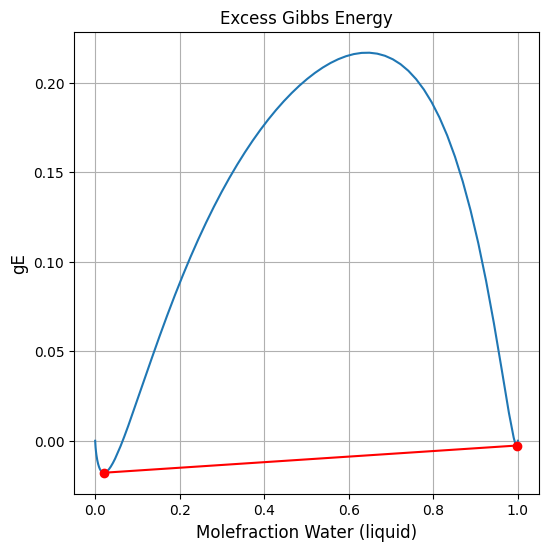

In [13]:
from plotFunctions import plotExcessGE, plotExcessGEZoomed, plotGamma
# plt.figure(figsize=(8,8))
# plotExcessGE(plt1,x2,sigmaxigammai,xL1,tangentPoint1,xL2,tangentPoint2)
plotExcessGE(plt,x2,sigmaxigammai,xL1,tangentPoint1,xL2,tangentPoint2,'Molefraction Water (liquid)','Excess Gibbs Energy')
#plotGamma(x2,gamm1,gamma2,['DCM','Water'])

By zooming in on the minimua of the above function, we can see the compositions where the phase split occurs:

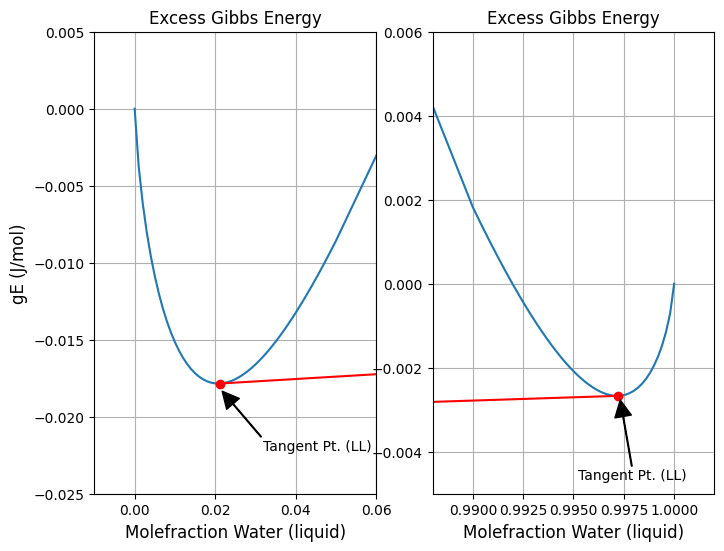

In [14]:
plotExcessGEZoomed(plt,x2,sigmaxigammai,xL1,tangentPoint1,xL2,tangentPoint2,'Molefraction Water (liquid)','Excess Gibbs Energy')

Plot the liquid phase activity coefficients calcualted from the NRTL model. The strong non-ideality is evident from the large values of $\gamma_{H2O}$ in the DCM-rich region, and of $\gamma_{DCM}$ in the water-rich region.

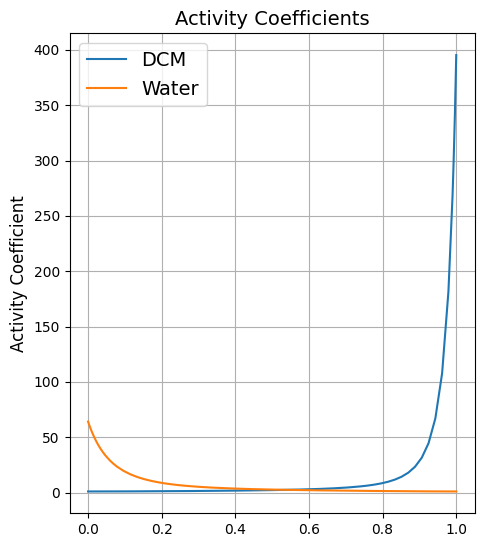

In [15]:
from plotFunctions import plotGamma
plt.figure(figsize=(6,6))
plotGamma(plt,x2,gamma1,gamma2,'Molefraction Water (liquid)','Activity Coefficients', ['DCM','Water'])


Plot the Txxy diagram using the data computed above:

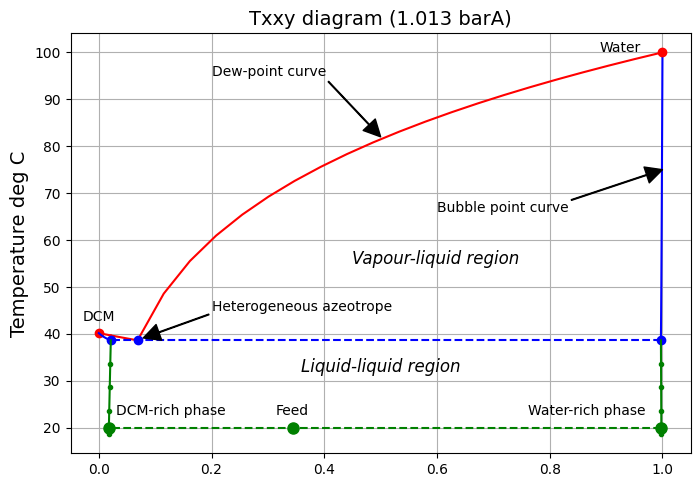

In [16]:
from plotFunctions import plotTxxy
plotTxxy(plt,x2_above_gap, TDew_above_gap,TBub_above_gap,yLLE,TLiq,TDew_below_gap,x2,TDew,x2_below_gap,
             x2_between_lower_gap_and_azeotrope,TDew_between_lower_gap_and_azeotrope,TBub_below_gap,x2_between_azeotrope_and_upper_gap, 
             TDew_between_azeotrope_and_upper_gap,xL1,xL2,TLLE,xLiq1,xLiq2,xInit,TInit,xInit1,xInit2)

By zooming in on the DCM-rich portion (left-side of below figure) we can see the location of the heterogeneous azeotrope (red dot) more clearly.  Similarly, the water rich region on the right hand side shows the location of the composition of the phase boundary (blue dot).

As the liquid feed (green dot) is heated, 

1. Temperature rises until at around 39.6C, it reaches the heterogeneous bubble point for the mixture. 
2. Further heating leads to depletion of the DCM-rich single phase, with vapour formating at the constant concentration of the heterogeous azeotrope, giving a vapour-liquid-liquid-equilibrium situation (VLLE)
3. When the DCM-rich single-phase has been depleted, the composition enters into a vapour-liquid-equilbrium (VLE) region where the liquid follows the bubble-point line between the azeotrope and pure-water
4. Eventually, the mixture reaches the dew-point line between the azetrope and pure-water; above this point there is only vapour.

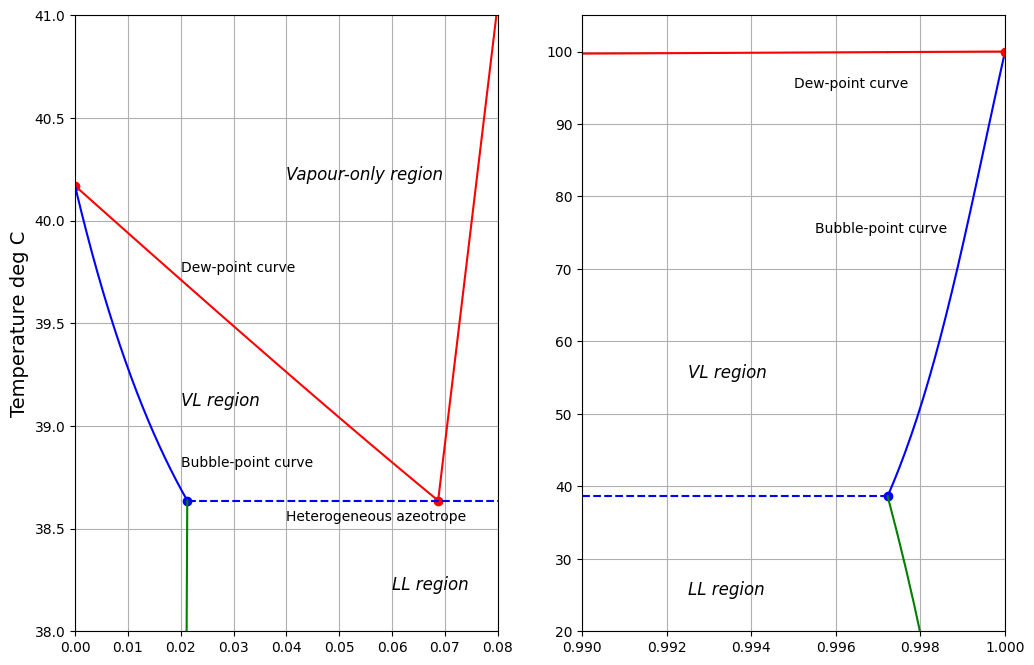

In [17]:
from plotFunctions import plotTxxyZoomed
plotTxxyZoomed(plt,x2_above_gap, TDew_above_gap,TBub_above_gap,yLLE,TLiq,TDew_below_gap,x2,TDew,x2_below_gap,
             x2_between_lower_gap_and_azeotrope,TDew_between_lower_gap_and_azeotrope,TBub_below_gap,x2_between_azeotrope_and_upper_gap, 
             TDew_between_azeotrope_and_upper_gap,xL1,xL2,TLLE,xLiq1,xLiq2)

The blue dots in the above diagram represent the compositions of liquid phases at saturation conditions for pressure of 1.0 barA.

Plot xy diagram below:

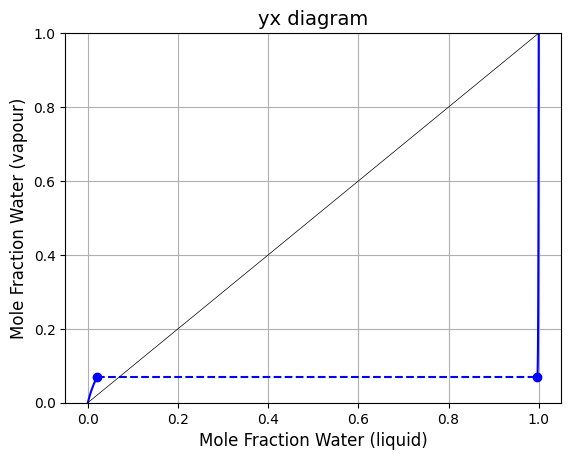

In [18]:
from plotFunctions import plotxy
plotxy(plt,x2_above_gap,yList_above_gap,x2_below_gap,yList_below_gap)

## Condenser Inlet Conditions

Flow rate into condenser is determined by the heat input into the vessel jacket, and by the composition of the azeotrope.

The vapour composition i.e. the composition of the binary heterogeous azeotrope is:

In [19]:
# print("Vapour composition (molefraction) :", yLLE )
print ("Binary composition (molefraction):", '[%s]' % ', '.join(map(str, ["%.3f" % float(elem) for elem in yLLE] )))


Binary composition (molefraction): [0.931, 0.069]


The heat input into the jacket is an assumed value:

In [20]:
Qin = 200*1000 # Watts
from IPython.display import Markdown as md
md("Heat input duty: {} kW".format(Qin/1000))

Heat input duty: 200.0 kW

Added to the flow of solvents will be an allowance for flow of inerts which leak into vessel under vacuum.

In [21]:
mAir = 2.72/3600 # kg/s
MWAir = 0.02896 # kg/mol
nAir = mAir/MWAir 
print("Mass flowrate of air:   {:0.3f} kg/hr".format(mAir*3600) )
print("Molar flowrate of air:  {:0.3f} kmol/hr".format(nAir*3600/1000))

Mass flowrate of air:   2.720 kg/hr
Molar flowrate of air:  0.094 kmol/hr


Calculate boilup rate based on initial composition and jacket heat-input $Q_{in}$:

In [49]:
from thermo import *
import functools
# constants, properties = ChemicalConstantsPackage.from_IDs(['water', 'dichloromethane', 'nitrogen'])

print("Latent heat of dichloromethane:  {:0.1f} J/mol".format(Chemical('dichloromethane').EnthalpyVaporization(298) ) )
print("Latent heat of water:            {:0.1f} J/mol".format(Chemical('water').EnthalpyVaporization(298) ) )

dHVL=yLLE[0]*Chemical('dichloromethane').EnthalpyVaporization(273+20)+yLLE[1]*Chemical('water').EnthalpyVaporization(273+20)
print("Weighted average  (at 20C):      {:0.1f} J/mol".format(dHVL))

moleFlowSolvent = Qin/dHVL  # mol/s
moleFlowInletTotal = moleFlowSolvent + nAir

moleFlowInlet = {'dichloromethane':  moleFlowSolvent*yLLE[0],
                 'water':            moleFlowSolvent*yLLE[1],
                 'inerts':           nAir} 

moleFractionInlet = {   'dichloromethane':      moleFlowInlet["dichloromethane"]/moleFlowInletTotal,
                        'water':               moleFlowInlet["water"]/moleFlowInletTotal,
                        'inerts':              moleFlowInlet["inerts"]/moleFlowInletTotal} 

# ySolventVapourIn= [moleFlowSolvent*yLLE[0]/moleFlowInletTotal,moleFlowSolvent*yLLE[1]/moleFlowInletTotal,nAir/moleFlowInletTotal ]
print ("Overall composition (molefraction):", '[%s]' % ', '.join(map(str, ["%.3f" % float(elem) for elem in ySolventVapourIn] )))

MWAvg = moleFractionInlet['dichloromethane']*Chemical('dichloromethane').MW +moleFractionInlet['water']*Chemical('water').MW + moleFractionInlet['inerts']*Chemical('nitrogen').MW
print("Average molecular weight:        {:0.1f} gm/mol".format(MWAvg))
print()
print("Solvent flowrate:                {:0.3f} mol/s".format(moleFlowSolvent) )
print("Total incl. non-condensibles:    {:0.3f} mol/s".format(moleFlowInletTotal ) )
print("Vapour inlet flow to condensers: {:0.1f} kg/hr".format(moleFlowInletTotal *MWAvg*3600/1000))
print()

print("DCM inlet flow:                  {:0.3f} mol/s: ".format(moleFlowInlet["dichloromethane"]) )
print("H2O inlet flow:                  {:0.3f} mol/s".format(moleFlowInlet["water"]) )
print("Inerts inlet flow:               {:0.3f} mol/s".format(moleFlowInlet["inerts"]) )         

print("DCM inlet molefraction:           {:0.3f} ".format(moleFractionInlet["dichloromethane"]) )
print("H2O inlet molefraction:           {:0.3f} ".format(moleFractionInlet["water"]) )
print("Inerts inlet molefraction:        {:0.3f} ".format(moleFractionInlet["inerts"]) ) 

Latent heat of dichloromethane:  29227.9 J/mol
Latent heat of water:            43993.9 J/mol
Weighted average  (at 20C):      30518.2 J/mol
Overall composition (molefraction): [0.928, 0.068, 0.004]
Average molecular weight:        80.1 gm/mol

Solvent flowrate:                6.553 mol/s
Total incl. non-condensibles:    6.580 mol/s
Vapour inlet flow to condensers: 1897.9 kg/hr

DCM inlet flow:                  6.103 mol/s: 
H2O inlet flow:                  0.450 mol/s
Inerts inlet flow:               0.026 mol/s
DCM inlet molefraction:           0.928 
H2O inlet molefraction:           0.068 
Inerts inlet molefraction:        0.004 


The configuration of a single condenser is depicted below. In the case of DCM/water, separate liquid phases are present, indicated by the flowrates $L_I$ and $L_{II}$, which combine to give an overall condensate flow of $L$.

The pressure $P$ is specified, as is the operating temperature $T$, which is assumed to approach the glycol inlet temperature to a specified extent.

In [ ]:
Image(url="condenserMassBalanceLiquidLiquid.png",width=800)

Equilibrium between the 2 liquid phases is given by (ref. Smith & van Ness p. 460):

$$
x_{DCM}^I \gamma_{DCM}^I  = x_{DCM}^{II} \gamma_{DCM}^{II}
$$
for DCM, and by

$$
x_{H2O}^I \gamma_{H2O}^I  = x_{H2O}^{II} \gamma_{H2O}^{II}
$$
where $I$ and $II$ represent the separate liquid phases in equilibrium. In each case, $\gamma$ is a function of composition and temperature.

A summation on molefraction in each phase is:
$$
x_{DCM}^I = 1- x_{H2O}^{I}
$$
and
$$
x_{DCM}^{II} = 1- x_{H2O}^{II}
$$
Vapour-liquid-liquid equilibrium (VLLE) is given by:

$$
y_{DCM} = \frac{x_{DCM}^{II} \gamma_{DCM}^{II}  p_{DCM}^S(T)}{P}
$$
$$
y_{H2O} = \frac{x_{H2O}^I \gamma_{H2O}^{I}  p_{H2O}^S(T)}{P}
$$
where $p_{DCM}^S$ and $p_{H2O}^S$ are vapour pressures, and $P$ is total pressure.

A summation of vapour molefraction is:
$$
y_{inerts} = 1- y_{DCM}- y_{H2O}
$$

An overall mass balance is given by:
$$
\Sigma F_i^{IN} = \Sigma G_i^{OUT} + L_{I} + L_{II}
$$
where $F_i^{IN}$ are the component molar feed inputs to the condenser, $G_i^{OUT}$ are component molar flowrates in vapour exiting. $L_{I}$ and $L_{II}$ are the molar flowrates of the separate liquid condensate phases.

Finally, component molar balances are given by:
$$
L_{I}x_{DCM}^I + L_{II}x_{DCM}^II = F_{DCM}^{IN} - G_{DCM}^{OUT}
$$
for DCM, and for H2O by:
$$
L_{I}x_{H2O}^I + L_{II}x_{H2O}^II = F_{H2O}^{IN} - G_{H2O}^{OUT}
$$

The above represents 10 non-linear equations in 10 unknowns: $L_{I}, L_{II}, x_{DCM}^I,x_{DCM}^{II},x_{H2O}^I,x_{H2O}^{II},y_{DCM},y_{H2O}, y_{INERTS},  G_{OUT} $  
  

The system of equations is solved numerically below in the "pyomo" framework, using the IPOPT solver.

In [50]:
from pyomo.environ import *
from tabulate import tabulate
from phasepy.actmodels import nrtl

inlet_conditions = [
    ["DCM",   np.round(moleFlowInlet["dichloromethane"],3), dichloromethane.Mw, np.round(moleFractionInlet["dichloromethane"],3),  np.round(moleFractionInlet["dichloromethane"]*P,3)],
    ["Water", np.round(moleFlowInlet["water"],3),           water.Mw,           np.round(moleFractionInlet["water"],3),  np.round(moleFractionInlet["water"]*P,3)],
    ["N2",    np.round(moleFlowInlet["inerts"],3),              28.0,           np.round(moleFractionInlet["inerts"],3),  np.round(moleFractionInlet["inerts"]*P,3)],
    ["Total:",np.round(moleFlowInletTotal,3),                    np.round(MWAvg,2),     "{:.4f}".format(sum(moleFractionInlet.values())),  "{:.4f}".format(sum(moleFractionInlet.values())*P)]
]


print("Inlet vapour conditions at {:0.1f} C: ".format(TLiq-273.2) )
table = tabulate(inlet_conditions, headers=["Component","Inlet flow (mol/s)", "Molecular Weight", \
                                  "Mole fraction","Partial Pressure (bar)",],\
                                    tablefmt='html',disable_numparse=True)

from IPython.display import HTML, display
display(HTML(table))
TCond = 10+273.16

L1List=[]
L2List=[]
ventFlow={'dichloromethane':[],'water':[],'inerts':[]}
percentCondensedDict ={'dichloromethane':[],'water':[],'inerts':[]}
condensateMolefraction = {'dichloromethane':[],'water':[] }

condenserTemperatureList=[35+273.2, 30+273.2, 25+273.2, 20+273.2, 15+273.2, 10+273.2, 5+273.2, 0+273.2, -5+273.2, -10+273.2, -15+273.2] #, , 5+273.2, 10+273.2, 15+273.2] #,15,10,5,0,-5,-10,-15]
for T in condenserTemperatureList:
    m = ConcreteModel()

    ## Define the objective to be a constant
    m.obj = Objective(expr=1)

    ## Define a set for components
    # ----------------------------
    m.COMPS = Set(initialize=["dichloromethane","water"])

    ################
    ## Parameters
    ################
    m.F_in = Param(initialize=moleFlowInletTotal)
    m.z = Param(m.COMPS, initialize={"dichloromethane":moleFractionInlet["dichloromethane"], "water":moleFractionInlet["water"]})

    # m.P = P
    m.P = Param(within=NonNegativeReals,initialize=P)
    m.T = Param(within=NonNegativeReals,mutable=True,initialize=T) #
    # print("Temperature  {:6.1f} [K]".format(value(m.T)))

    ################
    ## Variables
    ################
    m.xL1      = Var(m.COMPS, bounds=(0, 1.0), initialize={"dichloromethane":0.99, "water":0.01})  # variable, indexed by the set "COMPS"
    m.xL2      = Var(m.COMPS, bounds=(0, 1.0), initialize={"dichloromethane":0.01, "water":0.99})  # variable, indexed by the set "COMPS"
    m.y        = Var(m.COMPS, bounds=(0, 1.0), initialize={"dichloromethane":0.90, "water":0.10})  # variable, indexed by the set "COMPS"

    m.yInerts       = Var(within=NonNegativeReals, initialize=moleFractionInlet["inerts"]) 
    m.L1            = Var(within=NonNegativeReals, initialize=moleFlowInlet["dichloromethane"]) 
    m.L2            = Var(within=NonNegativeReals, initialize=moleFlowInlet["water"])
    m.F_out         = Var(within=NonNegativeReals, initialize=moleFlowInletTotal)

    ##########################
    ## Constraint declarations
    ##########################
    # equation 1: overall mass balance
    # --------------------------------
    m.overall_mass_balance = Constraint(expr=m.F_in == m.F_out + m.L1 + m.L2)

    # equations 2a / 2b: component mass balances
    # ------------------------------------------
    def eq_comp_mass_balance(m, c):
        ''' model: Pyomo model
            c: set for components
        '''
        return m.F_in*m.z[c] == m.xL1[c]*m.L1 + m.xL2[c]*m.L2 + m.F_out*m.y[c]

    m.component_mass_balance= Constraint(m.COMPS, rule=eq_comp_mass_balance)

    # equation 4a/4b: Liquid-liquid equilibria
    # ----------------------------------------
    m.LLE_L1 = Constraint( expr= m.xL1["dichloromethane"]*( np.exp( nrtl([m.xL1["dichloromethane"].value,1-m.xL1["dichloromethane"].value],m.T.value,alpha, Aij0, Aij1)[0] ) ) == 
                        m.xL2["dichloromethane"]*( np.exp( nrtl([m.xL2["dichloromethane"].value,1-m.xL2["dichloromethane"].value],m.T.value,alpha, Aij0, Aij1)[0] )  ) )

    m.LLE_L2 = Constraint( expr= m.xL1["water"]*( np.exp( nrtl([m.xL1["dichloromethane"].value,1-m.xL1["dichloromethane"].value],m.T.value,alpha, Aij0, Aij1)[1] ) ) == 
                        m.xL2["water"]*( np.exp( nrtl([m.xL2["dichloromethane"].value,1-m.xL2["dichloromethane"].value],m.T.value,alpha, Aij0, Aij1)[1] )  ) )

    # equation 5a/5b/5c: molefraction summation constraints
    # ----------------------------------
    m.summation_L1 = Constraint( expr= m.xL1["dichloromethane"] + m.xL1["water"] == 1 )
    m.summation_L2 = Constraint( expr= m.xL2["dichloromethane"] + m.xL2["water"] == 1 )
    m.summation_V  = Constraint( expr= m.y["dichloromethane"] + m.y["water"] +m.yInerts == 1 )

    # equation 6a/6b: Vapour-liquid equilibria
    # ----------------------------------------
    m.VLE1  = Constraint( expr= m.y["dichloromethane"]  == m.xL2["dichloromethane"]*np.exp(  nrtl([ m.xL2["dichloromethane"].value, 1-m.xL2["dichloromethane"].value ],m.T.value,alpha, Aij0, Aij1)[0] ) *dichloromethane.psat(m.T.value) /m.P )   
    m.VLE2  = Constraint( expr= m.y["water"]            == m.xL1["water"]*np.exp( nrtl([ m.xL1["dichloromethane"].value, 1-m.xL1["dichloromethane"].value ],m.T.value,alpha, Aij0, Aij1)[1] ) *water.psat(m.T.value) /m.P )

    ## Print model
    # m.pprint()

    #############
    ## Solver
    #############
    # print("Solving for T= ", m.T.value)
    # print("=======================")
    solver = SolverFactory('ipopt')
    results = solver.solve(m, tee = False)

    # print("Pressure     {:6.3f} [bar]".format(value(m.P)))
    # print("Temperature  {:6.1f} [K]".format(value(m.T)))
    # print("Temperature  {:6.1f} [K]".format(m.T))
    # print("yInerts_in: {:6.3f}".format(moleFractionInlet["inerts"]))
    # print("yDCM_in: {:6.3f}".format(moleFractionInlet["dichloromethane"]))
    # print("yH2O_in: {:6.3f}".format(moleFractionInlet["water"]))
    # print("Flow in:  {:6.6e}".format(moleFlowInletTotal))
    # print("Flow out: {:6.6e}".format(value(m.L1)+value(m.L2)+value(m.F_out) ))
    # print("L1   = {:6.6f} [mol/s]".format(value(m.L1)))
    # print("L2   = {:6.6f} [mol/s]".format(value(m.L2)))
    # print("Vent = {:6.6f} [mol/s]".format(value(m.F_out)))
    # print()
    # print("xL1['dichloromethane'] = {:6.6f} [-]".format(value(m.xL1["dichloromethane"])))
    # print("xL1['water'] = {:6.6f} [-]".format(value(m.xL1["water"])))
    # print("xL2['dichloromethane'] = {:6.6f} [-]".format(value(m.xL2["dichloromethane"])))
    # print("xL2['water'] = {:6.6f} [-]".format(value(m.xL2["water"])))
    # print()
    # print("y['dichloromethane'] = {:6.3f} [-]".format(value(m.y["dichloromethane"])))
    # print("y['water'] = {:6.3f} [-]".format(value(m.y["water"])))
    # print("y['inerts'] = {:6.3f} [-]".format(value(m.yInerts)))
    gammaI  = { 'dichloromethane':  np.exp( nrtl([m.xL1["dichloromethane"].value,1-m.xL1["dichloromethane"].value],m.T.value,alpha, Aij0, Aij1)[0] ),
                'water':             np.exp( nrtl([m.xL1["dichloromethane"].value,1-m.xL1["dichloromethane"].value],m.T.value,alpha, Aij0, Aij1)[1] )} 
    gammaII = {'dichloromethane':   np.exp( nrtl([m.xL2["dichloromethane"].value,1-m.xL2["dichloromethane"].value],m.T.value,alpha, Aij0, Aij1)[0] ),
                'water':             np.exp( nrtl([m.xL2["dichloromethane"].value,1-m.xL2["dichloromethane"].value],m.T.value,alpha, Aij0, Aij1)[1] )} 

    percentCondensed = {'dichloromethane':   100*(1-value(m.F_out)*value(m.y["dichloromethane"])/moleFlowInlet["dichloromethane"]),
                        'water':             100*(1-value(m.F_out)*value(m.y["water"])/moleFlowInlet["water"]),
                        'inerts':            100*(1-value(m.F_out)*value(m.yInerts)/moleFlowInlet["inerts"]),
                        'total':             100*(1-value(m.F_out)/moleFlowInletTotal)}

    L1List.append(value(m.L1))   
    L2List.append(value(m.L2)) 
    ventFlow['dichloromethane'].append(value(m.F_out)*value(m.y["dichloromethane"]))
    ventFlow['water'].append(value(m.F_out)*value(m.y["water"]))
    ventFlow['inerts'].append(value(m.F_out)*value(m.yInerts))

    percentCondensedDict['dichloromethane'].append( percentCondensed['dichloromethane'] )
    percentCondensedDict['water'].append( percentCondensed['water'] )

    condensateMolefraction['dichloromethane'].append( (value(m.L1)*value(m.xL1["dichloromethane"]) + value(m.L2)*value(m.xL2["dichloromethane"]))/( value(m.L1)+value(m.L2) ) )
    condensateMolefraction['water'].append( (value(m.L1)*value(m.xL1["water"]) + value(m.L2)*value(m.xL2["water"]))/( value(m.L1)+value(m.L2) ) )
    
# print("gamma(DCM) phase I:  ", gammaI["dichloromethane"])
# print("gamma(DCM) phase II: ", gammaII["dichloromethane"])  
# print("gamma(H2O) phase I:  ", gammaI["water"])
# print("gamma(H2O) phase II: ", gammaII["water"])

xDCM = (value(m.L1)*value(m.xL1["dichloromethane"])+value(m.L2)*value(m.xL2["dichloromethane"]))/(value(m.L1)+value(m.L2))
xH2O = (value(m.L1)*value(m.xL1["water"])+value(m.L2)*value(m.xL2["water"]))/(value(m.L1)+value(m.L2))

print("Overall Mass Balance at gas/vapour exit temperature of {:0.1f} C: ".format(T-273.2) )
print()
from IPython.display import HTML, display
sumyOut = value(m.y["dichloromethane"])+value(m.y["water"])+value(m.yInerts)
condenser_result_table = [
    ["DCM:",     moleFlowInlet["dichloromethane"],   moleFractionInlet["dichloromethane"],  "{:.4f}".format(value(m.L1)*value(m.xL1["dichloromethane"])),    "{:.4f}".format(value(m.xL1["dichloromethane"])),   "{:.6f}".format(value(m.L2)*value(m.xL2["dichloromethane"])),   "{:.6f}".format(value(m.xL2["dichloromethane"])),  "{:.6f}".format(xDCM), "{:.6e}".format(value(m.F_out)*value(m.y["dichloromethane"])),  "{:.6f}".format(value(m.y["dichloromethane"])), "{:3.2f}".format(percentCondensed['dichloromethane'])],
    ["Water:",   moleFlowInlet["water"],             moleFractionInlet["water"],            "{:.6f}".format(value(m.L1)*value(m.xL1["water"])),              "{:.6f}".format(value(m.xL1["water"])),             "{:.6f}".format(value(m.L2)*value(m.xL2["water"])),             "{:.6f}".format(value(m.xL2["water"])),            "{:.6f}".format(xH2O), "{:.6e}".format(value(m.F_out)*value(m.y["water"])),            "{:.6f}".format(value(m.y["water"])), "{:.2f}".format(percentCondensed['water'])],
    ["Inerts:",  moleFlowInlet["inerts"],            moleFractionInlet["inerts"],            "N/A",                                                          "N/A",                                              "N/A",                                                          "N/A",                                               "N/A",                 "{:.6f}".format(value(m.F_out)*value(m.yInerts)),               "{:.6f}".format(value(m.yInerts)), "{:.2f}".format(percentCondensed['inerts'])],
    ["Totals:",  sum(moleFlowInlet.values()),        sum(moleFractionInlet.values()),        "{:.4f}".format(value(m.L1)),                                   "{:.4f}".format(value(m.xL1["dichloromethane"])+value(m.xL1["water"])),   "{:.4f}".format(value(m.L2)), "{:.4f}".format(value(m.xL2["dichloromethane"])+value(m.xL2["water"])) ,   "N/A",  "{:.6f}".format(value(m.F_out)),    sumyOut, "{:.2f}".format(percentCondensed['total'])]
    ]
table = tabulate(condenser_result_table , headers=["Component","Inlet flowrate (mol/s)","Inlet Molefraction", "Phase 1 flowrate (mol/s)", 
                                                "Phase 1 molefraction", "Phase 2 flowrate (mol/s)", "Phase 2 molefraction", "Liquid Flow (total)", "Vent flowrate (mol/s)", "Vent molefraction", "% Condensed"],\
                                    tablefmt='html',floatfmt=".3f")
display(HTML(table))

phases_result_table = [
    ["Inlet",   "{:.4f}".format(sum(moleFlowInlet.values())), "{:.4f}".format(moleFractionInlet["dichloromethane"]), "{:.4f}".format(moleFractionInlet["water"]),"{:.4f}".format(moleFractionInlet["inerts"]), "N/A", "N/A"],
    ["Vent",    "{:.4f}".format(value(m.F_out)), "{:.4f}".format(value(m.y["dichloromethane"])), "{:.4f}".format(value(m.y["water"])),"{:.4f}".format(value(m.yInerts)), "N/A", "N/A"],
    ["Organic", "{:.4f}".format(value(m.L1)), "{:.4f}".format(value(m.xL1["dichloromethane"])), "{:.4f}".format(value(m.xL1["water"])),"N/A", "{:.4f}".format(gammaI["dichloromethane"]), "{:.4f}".format(gammaI["water"])],
    ["Aqueous", "{:.4f}".format(value(m.L2)), "{:.4f}".format(value(m.xL2["dichloromethane"])), "{:.4f}".format(value(m.xL2["water"])),"N/A", "{:.4f}".format(gammaII["dichloromethane"]), "{:.4f}".format(gammaII["water"])],
    ["Total Liquid","{:.4f}".format(value(m.L1)+value(m.L2)), "{:.4f}".format(xDCM), "{:.4f}".format(xH2O),"N/A","N/A","N/A"]
]
table = tabulate(phases_result_table , headers=["Phase","Phase flowrate (mol/s)", "DCM Molefraction", "Water Molefraction", "Inerts Molefraction", "Activity Coefficient (DCM)", "Activity Coefficient (Water)"],\
                                    tablefmt='html')
display(HTML(table))

# print("L1 (list): ", L1List)
# print("L2 (list): ", L2List)


Inlet vapour conditions at 38.6 C: 


Component,Inlet flow (mol/s),Molecular Weight,Mole fraction,Partial Pressure (bar)
DCM,6.103,84.93,0.928,0.94
Water,0.45,18.02,0.068,0.069
N2,0.026,28.0,0.004,0.004
Total:,6.58,80.13,1.0000,1.0130


Overall Mass Balance at gas/vapour exit temperature of -15.0 C: 



Component,Inlet flowrate (mol/s),Inlet Molefraction,Phase 1 flowrate (mol/s),Phase 1 molefraction,Phase 2 flowrate (mol/s),Phase 2 molefraction,Liquid Flow (total),Vent flowrate (mol/s),Vent molefraction,% Condensed
DCM:,6.103,0.928,6.1000,0.9884,0.000649,0.001711,0.931263,0.003,0.088,99.960
Water:,0.450,0.068,0.071666,0.011612,0.378621,0.998289,0.068737,0.000,0.002,99.990
Inerts:,0.026,0.004,N/A,N/A,N/A,N/A,N/A,0.026,0.910,-0.000
Totals:,6.580,1.000,6.1716,1.0000,6.1716,1.0000,N/A,0.029,1.000,99.560


Phase,Phase flowrate (mol/s),DCM Molefraction,Water Molefraction,Inerts Molefraction,Activity Coefficient (DCM),Activity Coefficient (Water)
Inlet,6.5796,0.9276,0.0684,0.0040,N/A,N/A
Vent,0.0287,0.088,0.0018,0.9102,N/A,N/A
Organic,6.1716,0.9884,0.0116,N/A,1.0014,83.4118
Aqueous,0.3793,0.0017,0.9983,N/A,951.3355,1.0001
Total Liquid,6.5509,0.9313,0.0687,N/A,N/A,N/A


### Plot condenser performance vs. gas/vapour exit temperature 

Dots on figure below represent a 7C gas/vapour temperature, corresponding to a 5C approach to 2C glycol inlet temperature.

Squares represent a -12C gas/vapour temperature, i.e. a 5C approach to -17C glycol inlet.

<Figure size 600x600 with 0 Axes>

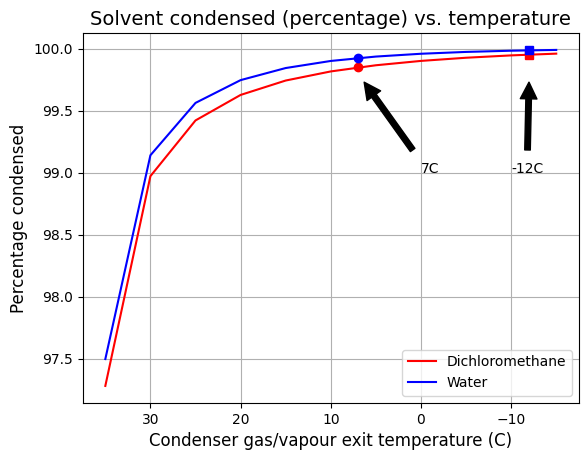

In [51]:
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
condenserTemperatureListCelcius = [t-273.2 for t in condenserTemperatureList]
plt.plot(condenserTemperatureListCelcius,percentCondensedDict['dichloromethane'],'-r')
plt.plot(condenserTemperatureListCelcius,percentCondensedDict['water'],'-b')

plt.xlabel('Condenser gas/vapour exit temperature (C)', fontsize=12)
plt.ylabel('Percentage condensed', fontsize=12)
plt.title('Solvent condensed (percentage) vs. temperature', fontsize=14)
plt.legend(['Dichloromethane','Water'])
plt.grid()
ax.annotate('7C', xy=(7, 99.8), xytext=(0, 99),
            arrowprops=dict(facecolor='black', shrink=0.1),)

reversedList = condenserTemperatureListCelcius[::-1]

from scipy.interpolate import CubicSpline
cs1 = CubicSpline(reversedList, percentCondensedDict['dichloromethane'][::-1])
cs2 = CubicSpline(reversedList, percentCondensedDict['water'][::-1])

T1 = 2+5 # Approach of 5C
plt.plot(T1, cs1(T1), 'or')
plt.plot(T1, cs2(T1), 'ob')

T1 = -17+5 # Approach of 5C
plt.plot(T1, cs1(T1), 'sr')
plt.plot(T1, cs2(T1), 'sb')
ax.annotate('-12C', xy=(-12, 99.8), xytext=(-10, 99),
            arrowprops=dict(facecolor='black', shrink=0.1),)

plt.gca().invert_xaxis()

### Fraction required to be distilled to reach single-phase boundary

As the distillation proceeds, the initial composition becomes richer in water (leaner in DCM) as the mixture composition tends towards the water-rich phase boundary at constant temperature.  Assuming "simple" or "Rayleigh" distillation, the total moles remaining in the reactor when the single-phase boundary is reached is given by

$$
ln \left( \frac{N_f}{N_i} \right) = \int_{x_{P2}}^{x_i} \frac{dx}{y_{AZ}-x}

$$

where $y_{AZ}$ is the (constant) vapour composition (basis=water), $x_i$ is the initial molefraction and $x_{P2}$ is the composition of the 2nd (water-rich) phase.  This reduces to:

$$
N_f = N_i exp \left[ ln \left( \frac{x_i + y_{AZ}}{x_f + y_{AZ}}  \right)  \right]

$$

The total distillate removed is simply $D=N_i-N_f$.

In [42]:
print("Total moles initially:               {:0.2f} kmol".format( NTotal_i ))
print("Initial water molefraction:           {:0.3f}".format( xInit[1] ))
print("Water molefraction of distillate:     {:0.3f}".format( yLLE[1] ))
print("Water molefraction at phase boundary: {:0.3f}".format( xL1[1] ))
Nf = NTotal_i*np.exp(np.log((-1*xInit[1]+yLLE[1])/(-1*xL1[1]+yLLE[1])))
print("Total moles at end (when x=0.997):    {:0.2f} kmol".format( Nf ))

D=NTotal_i-Nf
print("Moles of distillate:                  {:0.2f} kmol".format( D ))

Total moles initially:               118.23 kmol
Initial water molefraction:           0.656
Water molefraction of distillate:     0.069
Water molefraction at phase boundary: 0.997
Total moles at end (when x=0.997):    74.80 kmol
Moles of distillate:                  43.43 kmol
